In [53]:
import nltk
import numpy as np
import pandas as ps
import matplotlib as mp
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

from surprise import SVD
from surprise import SVDpp
from surprise import NMF

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic
from surprise import KNNWithMeans



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guillaume\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
donnees = ps.read_csv("Reviews.csv")
donnees = donnees.drop_duplicates(subset={"ProductId","UserId","ProfileName"})

In [3]:
donnees.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,560808.00000,560808.000000,560808.000000,560808.000000,5.608080e+05
mean,284312.54404,1.743121,2.225291,4.183079,1.296553e+09
std,164097.91590,7.666340,8.315820,1.310527,4.796648e+07
min,1.00000,0.000000,0.000000,1.000000,9.393408e+08
25%,142241.75000,0.000000,0.000000,4.000000,1.271894e+09
50%,284317.50000,0.000000,1.000000,5.000000,1.311466e+09
75%,426470.25000,2.000000,2.000000,5.000000,1.332893e+09
max,568454.00000,866.000000,923.000000,5.000000,1.351210e+09



Moyenne de score très haute avec peu de variance --> Est-ce que seuls les utilisateurs ayant eu une bonne expé notent les produits ou bien est-ce car il n'y a réellement que peu d'expériences négatives

In [4]:
donnees.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
data_par_id = donnees.groupby("ProductId").count().sort_values("Score",ascending=False)
data_par_id

,Id,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
ProductId,,,,,,,,,
B007JFMH8M,913,913,913,913,913,913,913,913,913
B003B3OOPA,623,623,623,623,623,623,623,623,623
B002QWP8H0,609,609,609,609,609,609,609,609,609
B002QWP89S,609,609,609,609,609,609,609,609,609
B002QWHJOU,609,609,609,609,609,609,609,609,609
...,...,...,...,...,...,...,...,...,...
B003YQBC0E,1,1,1,1,1,1,1,1,1
B003YQ3JBO,1,1,1,1,1,1,1,1,1
B003YQ3ED2,1,1,1,1,1,1,1,1,1



Au dessus, les produits les plus souvent notés On va voir quels sont les score moyens pour les 5 plus souvent notés

In [6]:
data_par_id = data_par_id.head(5)

cols = data_par_id.index.values
cols


for i in cols:
    print("Numéro de produit : ",i)
    print("Moyenne du score pour cet item : ",donnees.where(donnees["ProductId"] == i)["Score"].mean())
    print("Ecart-type du score pour cet item : ",donnees.where(donnees["ProductId"] == i)["Score"].std())
    print("Critère helpfulness moyen",(donnees.where(donnees["ProductId"] == i)["HelpfulnessNumerator"]/donnees.where(donnees["ProductId"] == i)["HelpfulnessDenominator"]).mean())


Numéro de produit :  B007JFMH8M
Moyenne du score pour cet item :  4.5826944140197154
Ecart-type du score pour cet item :  0.7055595108853531
Critère helpfulness moyen 0.9010416666666666
Numéro de produit :  B003B3OOPA
Moyenne du score pour cet item :  4.739967897271268
Ecart-type du score pour cet item :  0.6683891459432163
Critère helpfulness moyen 0.8782740957320783
Numéro de produit :  B002QWP8H0
Moyenne du score pour cet item :  4.584564860426929
Ecart-type du score pour cet item :  0.9664562485740971
Critère helpfulness moyen 0.7784390056269347
Numéro de produit :  B002QWP89S
Moyenne du score pour cet item :  4.584564860426929
Ecart-type du score pour cet item :  0.9664562485740971
Critère helpfulness moyen 0.7784390056269347
Numéro de produit :  B002QWHJOU
Moyenne du score pour cet item :  4.584564860426929
Ecart-type du score pour cet item :  0.9664562485740971
Critère helpfulness moyen 0.7784390056269347



On ne sait pas si l'égalité entre les 3 derniers est normale, purement due au hasard, ou pas (même si ça n'a pas l'air probable, c'est pas impossible qu'avec le nombre important de données dans le dataset, les différences entre les valeurs moyennes ne puissent pas être visible par le biais d'un flottant)

Donc bien qu'on ait un numéro de produit différent, il semble que plusieurs des entrées du jeu de données soient en fait dupliquées, ou bien que plusieurs identifients de produits pointent vers le même produit (mais ce qui ne devrait pas être le cas dans ce dataset)

866

In [25]:
donnees

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


Text(0.5, 1.0, 'Histogramme du Score')

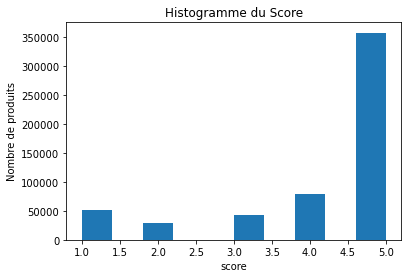

In [57]:
plt.hist(donnees["Score"])
plt.xlabel('score')
plt.ylabel('Nombre de produits')
plt.title('Histogramme du Score')

Text(0.5, 1.0, 'Histogramme du HelpfulnessNumerator')

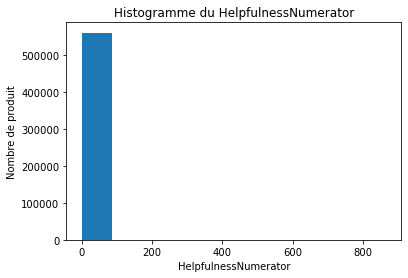

In [58]:
plt.hist(donnees["HelpfulnessNumerator"])
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('Nombre de produit')
plt.title('Histogramme du HelpfulnessNumerator')

Le max du HelpfulnessNumerator est 866, sauf qu'il y en a très peu avec un HelpfulnessNumerator si grand. Donc si on prend les HelpfulnessNumerator entre 0 et 100 :

Text(0.5, 1.0, 'Histogramme du HelpfulnessNumerator')

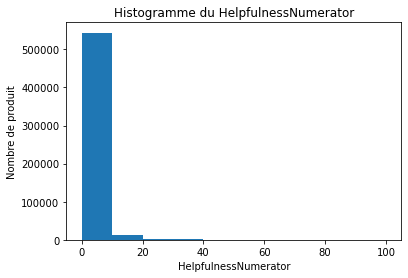

In [59]:
plt.hist(donnees["HelpfulnessNumerator"], range=(0,100))
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('Nombre de produit')
plt.title('Histogramme du HelpfulnessNumerator')

Et entre 0 et 10 :

Text(0.5, 1.0, 'Histogramme du HelpfulnessNumerator')

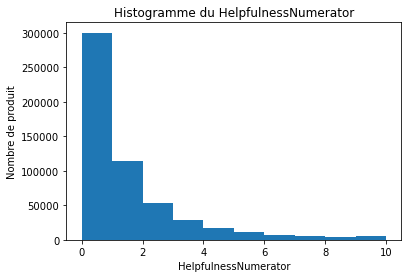

In [60]:
plt.hist(donnees["HelpfulnessNumerator"], range=(0,10))
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('Nombre de produit')
plt.title('Histogramme du HelpfulnessNumerator')

Pareil pour HelpfulnessDenominator, le max est 923 :

Text(0.5, 1.0, 'Histogramme du HelpfulnessDenominator')

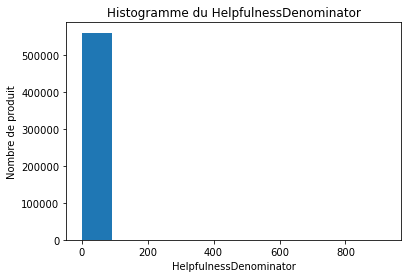

In [61]:
plt.hist(donnees["HelpfulnessDenominator"])
plt.xlabel('HelpfulnessDenominator')
plt.ylabel('Nombre de produit')
plt.title('Histogramme du HelpfulnessDenominator')

Text(0.5, 1.0, 'Histogramme du HelpfulnessDenominator ')

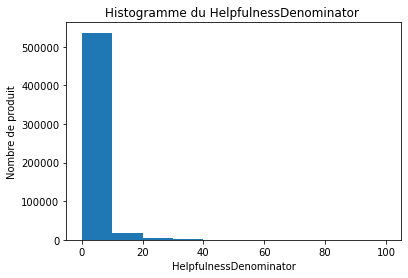

In [62]:
plt.hist(donnees["HelpfulnessDenominator"], range=(0,100))
plt.xlabel('HelpfulnessDenominator')
plt.ylabel('Nombre de produit')
plt.title('Histogramme du HelpfulnessDenominator ')

Text(0.5, 1.0, 'Histogramme du HelpfulnessDenominator ')

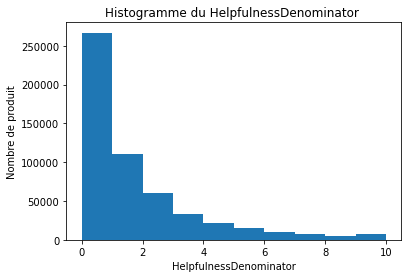

In [63]:
plt.hist(donnees["HelpfulnessDenominator"], range=(0,10))
plt.xlabel('HelpfulnessDenominator')
plt.ylabel('Nombre de produit')
plt.title('Histogramme du HelpfulnessDenominator ')

Text(0.5, 1.0, 'Histogramme du HelpfulnessDenominator ')

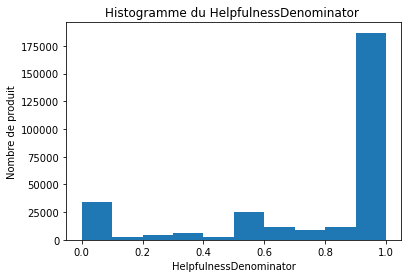

In [81]:
plt.hist((donnees["HelpfulnessNumerator"]/donnees["HelpfulnessDenominator"]), range=(0,1))
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('HelpfulnessDenominator')
plt.title('Histogramme ratio HelpfulnessNumerator/HelpfulnessDenominator ')

In [5]:
donnees.loc[donnees["ProductId"] == 'B002QWP8H0']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
355503,355504,B002QWP8H0,A21U4DR8M6I9QN,"K. M Merrill ""justine""",1,1,5,1318896000,addictive! but works for night coughing in dogs,my 12 year old sheltie has chronic brochotitis...
355504,355505,B002QWP8H0,A17TDUBB4Z1PEC,jaded_green,1,1,5,1318550400,genuine Greenies best price,"These are genuine Greenies product, not a knoc..."
355505,355506,B002QWP8H0,ABQH3WAWMSMBH,tenisbrat87,1,1,5,1317168000,Perfect for our little doggies,"Our dogs love Greenies, but of course, which d..."
355506,355507,B002QWP8H0,AVTY5M74VA1BJ,tarotqueen,1,1,5,1316822400,dogs love greenies,"What can I say, dogs love greenies. They begg ..."
355507,355508,B002QWP8H0,A13TNN54ZEAUB1,dcz2221,1,1,5,1316736000,Greenies review,This review is for a box of Greenies Lite for ...
...,...,...,...,...,...,...,...,...,...,...
356129,356130,B002QWP8H0,A3COGF8HVN6IPZ,madhatter,1,1,5,1320019200,Wonder where the tartar went.............,I was a skeptic. I thought I would have to ha...
356131,356132,B002QWP8H0,A1HZIWB1RGW7RM,Danny Knowles,1,1,5,1319673600,Greenies,These are the best things since sliced bread. ...
356132,356133,B002QWP8H0,A1Q5SEO5O6E0L4,brendab,1,1,5,1319673600,my dog loves these,My dog loves these. I received a sample at th...
356133,356134,B002QWP8H0,AFMF7YL0PKFIM,Jan,1,1,5,1319068800,Greenies Dental Chews -Teenies,"Oh my gosh, we cannot be without Greenies at o..."


In [6]:
donnees.loc[donnees["ProductId"] == 'B002QWP89S']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
20982,20983,B002QWP89S,A21U4DR8M6I9QN,"K. M Merrill ""justine""",1,1,5,1318896000,addictive! but works for night coughing in dogs,my 12 year old sheltie has chronic brochotitis...
20983,20984,B002QWP89S,A17TDUBB4Z1PEC,jaded_green,1,1,5,1318550400,genuine Greenies best price,"These are genuine Greenies product, not a knoc..."
20984,20985,B002QWP89S,ABQH3WAWMSMBH,tenisbrat87,1,1,5,1317168000,Perfect for our little doggies,"Our dogs love Greenies, but of course, which d..."
20985,20986,B002QWP89S,AVTY5M74VA1BJ,tarotqueen,1,1,5,1316822400,dogs love greenies,"What can I say, dogs love greenies. They begg ..."
20986,20987,B002QWP89S,A13TNN54ZEAUB1,dcz2221,1,1,5,1316736000,Greenies review,This review is for a box of Greenies Lite for ...
...,...,...,...,...,...,...,...,...,...,...
21608,21609,B002QWP89S,A3COGF8HVN6IPZ,madhatter,1,1,5,1320019200,Wonder where the tartar went.............,I was a skeptic. I thought I would have to ha...
21610,21611,B002QWP89S,A1HZIWB1RGW7RM,Danny Knowles,1,1,5,1319673600,Greenies,These are the best things since sliced bread. ...
21611,21612,B002QWP89S,A1Q5SEO5O6E0L4,brendab,1,1,5,1319673600,my dog loves these,My dog loves these. I received a sample at th...
21612,21613,B002QWP89S,AFMF7YL0PKFIM,Jan,1,1,5,1319068800,Greenies Dental Chews -Teenies,"Oh my gosh, we cannot be without Greenies at o..."


In [7]:
donnees.loc[donnees["ProductId"] == 'B002QWHJOU']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
329412,329413,B002QWHJOU,A21U4DR8M6I9QN,"K. M Merrill ""justine""",1,1,5,1318896000,addictive! but works for night coughing in dogs,my 12 year old sheltie has chronic brochotitis...
329413,329414,B002QWHJOU,A17TDUBB4Z1PEC,jaded_green,1,1,5,1318550400,genuine Greenies best price,"These are genuine Greenies product, not a knoc..."
329414,329415,B002QWHJOU,ABQH3WAWMSMBH,tenisbrat87,1,1,5,1317168000,Perfect for our little doggies,"Our dogs love Greenies, but of course, which d..."
329415,329416,B002QWHJOU,AVTY5M74VA1BJ,tarotqueen,1,1,5,1316822400,dogs love greenies,"What can I say, dogs love greenies. They begg ..."
329416,329417,B002QWHJOU,A13TNN54ZEAUB1,dcz2221,1,1,5,1316736000,Greenies review,This review is for a box of Greenies Lite for ...
...,...,...,...,...,...,...,...,...,...,...
330038,330039,B002QWHJOU,A3COGF8HVN6IPZ,madhatter,1,1,5,1320019200,Wonder where the tartar went.............,I was a skeptic. I thought I would have to ha...
330040,330041,B002QWHJOU,A1HZIWB1RGW7RM,Danny Knowles,1,1,5,1319673600,Greenies,These are the best things since sliced bread. ...
330041,330042,B002QWHJOU,A1Q5SEO5O6E0L4,brendab,1,1,5,1319673600,my dog loves these,My dog loves these. I received a sample at th...
330042,330043,B002QWHJOU,AFMF7YL0PKFIM,Jan,1,1,5,1319068800,Greenies Dental Chews -Teenies,"Oh my gosh, we cannot be without Greenies at o..."


In [9]:
##Test de comparaison 

donnees.loc[donnees["ProductId"] == 'B002QWHJOU'] == donnees.loc[donnees["ProductId"] == 'B002QWP89S'] 

ValueError: Can only compare identically-labeled DataFrame objects

In [5]:
texte_par_prod = dict()

for ind in donnees.index: 
    if not donnees["ProductId"][ind] in texte_par_prod.keys():#On ajoute le commentaire de chaque user pour un produit donné.
        texte_par_prod[donnees["ProductId"][ind]] = ""
    for w in donnees["Text"][ind]:
        if w not in stopwords.words():
            texte_par_prod[donnees["ProductId"][ind]] += w
    texte_par_prod[donnees["ProductId"][ind]] += "\n"
    

KeyboardInterrupt: 

In [4]:
texte_par_prod = dict()
k = 0
for ind in donnees.index: 
    if k>1000:
        break
    print(donnees["Text"][ind])
    if not donnees["ProductId"][ind] in texte_par_prod.keys():#On ajoute le commentaire de chaque user pour un produit donné.
        texte_par_prod[donnees["ProductId"][ind]] = ""
    for w in donnees["Text"][ind]:
        if w not in stopwords.words("english"):
            texte_par_prod[donnees["ProductId"][ind]] += w
    texte_par_prod[donnees["ProductId"][ind]] += "\n"
    k+=1

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
If you are looking for the secret i

This offer is a great price and a great taste, thanks Amazon for selling this product.<br /><br />Staral
McCann's Instant Oatmeal is great if you must have your oatmeal but can only scrape together two or three minutes to prepare it. There is no escaping the fact, however, that even the best instant oatmeal is nowhere near as good as even a store brand of oatmeal requiring stovetop preparation.  Still, the McCann's is as good as it gets for instant oatmeal. It's even better than the organic, all-natural brands I have tried.  All the varieties in the McCann's variety pack taste good.  It can be prepared in the microwave or by adding boiling water so it is convenient in the extreme when time is an issue.<br /><br />McCann's use of actual cane sugar instead of high fructose corn syrup helped me decide to buy this product.  Real sugar tastes better and is not as harmful as the other stuff. One thing I do not like, though, is McCann's use of thickeners.  Oats plus water plus heat should mak

we're used to spicy foods down here in south texas and these are not at all spicy.  doubt very much habanero is used at all.  could take it up a notch or two.
I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively.
We roast these in a large cast iron pan on the grill (about 1/3 of the bag at a time).  The smell is wonderful and the roasted beans taste delicious too.  More importantly, the coffee is smooth; no bitter aftertaste.  On numerous occasions, we've had to send the roasted beans home with friends because they like it so much.
Deal was awesome!  Arrived before Halloween as indicated and was enough to satisfy trick or treaters.  I love the quality of this pro

It is okay.  I would not go out of my way to buy it again
No tea flavor at all. Just whole brunch of artifial flavors. It is not returnable. I wasted 20+ bucks.
These looked like a perfect snack to through in with my trail mix.  Unfortunately, they arrived in a solid mass of melted chocolate.  I left them in my pantry for a few days, and when I opened them at room temperature they were still gooey.  I through them in the fridge and I've been breaking off hunks ever since.  They taste good to me, but the chocolate is all grainy after melting and then solidifying again.  I won't order them online again, but if I see them in a store I would pick them up.
These taste really good. I have been purchasing a different brand and these are very similar in taste and texture. I agree with the other reviewer regarding ordering in the summer. There is no insulating packaging with ice packs so they will melt in warm weather like all chocolate food items. Order in cold weather and buy enough to last!!

Our pup has experienced allergies in forms of hotspots and itching from other dog foods. The cheap 'you can buy it anywhere' food not only have crazy preservatives in them but can cause health problems for your pets.  This food works wonders on reducing allergies and our dog loves the food.<br />This message is RAMSEY FrAnkenSteiN approved.
My English Bulldog had skin allergies the summer we got him at age 3.  The vet recommended we wean him off the food his previous owner gave him (Iams Lamb and Rice) and onto a new kind.  This was the second one we tried, and it has been working ever since.  It's for dogs that need a limited diet who can be sensitive to additives and proteins commonly found in commercial dog food (like chicken or beef).
I fed this to my Golden Retriever and he hated it.  He wouldn't eat it, and when he did, it gave him terrible diarrhea.  We will not be buying this again.  It's also super expensive.
The mouth says, "How do I love thee, let me count the ways..."<br />

I started buying this after I noticed my 1 year old cat was already starting to lose his "spunk" so I decided it was time to start buying him "real" cat food...not the garbage in the super markets. I found this at the pet store out of the other million choices, and I'm sure there are other brands that are just as good but this is the one I went with to try first and it was a great purchase. My cat has been on this for the past 8 months and he's now just has active as he was when he was a kitten and his coat has became sooo soft. Mainly, he loved the taste even more! I highly recommend this brand to all my friends and family for their animals!
I have done a lot of research to find the best food for my cat, and this is an excellent food.  That is also according to my holistic veterinarian.  They put probiotics on the kibble as the last step, which is very important to me.  The best thing is that my cat loved it immediately and I had to stop mixing it with the old food because she only wo

I might be mistaken, but it appears that the pieces in this bag were reduced in size.  If they did do that, it was doubtlessly done to make it appear that the buyer got a better deal, having so many pieces after all.  The problem is that the pieces have to be a certain size in order to have enough flavor for your eating experience.  As it is, you have to use 2 or 3 pieces to match the old piece size;  it is not the same.
Being a fan of Newman's Pineapple salsa for quite a while, I was looking for a comparable salsa.  This is one of the best tasting salsas I've ever had.  My daughters love it too.  They don't like super chunky salsa and the Berry Mango has a nice smooth texture with small mango pieces.  The salsa is not too sweet, just sweet enough and although it's mild, it has a nice little kick to it.  At this price, it's a steal!
The SALSA smelled delicious, as I think it probably was - but, unfortunately, the person, at AMAZON, that is a packer (there is probably several) had very 

I used to love these growing up and stopped drinking water and lemon juice from this brand about 5-6 years ago. This stuff used to be so strong i used to just pour some in my mouth and get that alive feeling going. It feels like the product went through changes which added more water or something to make it not so strong. The stronger it is the less you use as well. The product is still really good but the taste is the same quality as the cheaper brand names almost. I thought  these would go fast but hey all lemon stuff i love unless it goes bad. This is a good product just wish it still had that hit me in the mouth chug sensation it used to be like.
One of the best lemon juice that I have tried. I am recurring customer due to the high quality of this product. When the season for fresh lemos is out, this one supplement our need for the citrus on the kitchen or refreshments.<br /><br />I will continue buying it.
This lemon juice is a must in my kitchen year-round. It has a powerful flav

I like these better than the regular Altoids, but they're even more costly, so you'd better like them.
These little tins of sugar free mine mints were a great deal.There perfict for on the go.Fifty mints per tin is just the right amount to cary along.And there safer for your teeth than the ones with sugar.The price of twelve dollars was very resonable.Also there great for shareing.If you are looking for a mint try these ones.Youll be glad you did.
Pros:<br />+packaging, shipping, price<br />+sold about a year before its expiration date (enough for me to eat/share 9 boxes)<br />+not too "fresh" like the regular wintergreen and not in a powdery form. it's a real mint!<br /><br />Cons: none!
Be careful not to eat too many of them in one day, as one of the chemicals in it is the same as that of a LAXATIVE!!! LOLOLOL!!!
These mints are really strong and have a great taste. They are also a convenient size to carry in a pocket or purse.
This is a huge supply of them. I'm still working on thes

Don't buy just a few of these!  I order these by the case.  I can't even remember the first time I tasted an anchovy stuffed olive but I have tried several of the brands online and this brand is my favorite.
I order these olives a lot. They are un-like any other olives out there. The subtle flavors of the brine go great with cheeses. One of my favorite appetizer treats for guests.
Hey, the description says 360 grams - that is roughly 13 ounces at under $4.00 per can. No way - that is the approximate price for a 100 gram can.
My husband and I are both kind of wimpy when it comes to hot things and this seasoning is just a bit too spicy for us. It definitely makes you sweat a bit when you're eating it. It was still edible to us by adding a good sized dollop of sour cream but I don't think I would buy it again due to the heat. We prefer the milder McCormick's brand of Fajita mix. I've also had fajitas in a couple of different restaurants and it wasn't as spicy as this mix is.<br /><br />If

The recommendation when we bought our puppies (lhasa/bichon mix and lhasa/poodle mix) was that we continue them on the food that they have had since being weaned. This is a somewhat expensive food so I can't say that we were terribly pleased but we loaded up on the stuff and headed home.<br /><br />Let me just say this, I have had small dogs before. Never have I seen such gas issues. Both of them consistently had foul gas. Consistently. Usually when they're sitting on our laps but, you know. They're dogs.<br /><br />When we got through the first bag of this stuff, we purchased more on amazon. It was a great price for it since we got a 40 lb bag for the price of (I think) a 15 lb bag at Petco. But, they continued to have gas. I mean, they loved the food, don't get me wrong and they loved it more when we'd mix in some water and it would be like soft food. Somehow that made their gas worse but I think I'll have to give that responsible to the speed with which they chowed down- can't blame

These Nature Valley Nut Lovers Variety Pack was perfect. Although I wasn't sure about the peanut butter bar, it was excellent. I loved the Roasted Almond, Roasted Pecan and the Peanut Butter.<br /><br />I will definately buy from this seller again. Quick shipping and very fresh.
I so wish I would have read this review before purchasing TWO gallons of this oil for my health issues. It reeks like a chemical rubber smell. This smell is coming from the black rubber gasket in the lid. When I called to report the situation to the company, Sabrina told me I would have to pay to send them a sample to have tested by a lab. Unbelievable. Good customer service would indicate that they would pay for the product to be returned and give me a full refund, including shipping. The product is faulty. Period. I will never order anything from this company again and do not recommend it to anyone based on this horrible customer service and lack of responsibility and ownership.
This product has a strong afte

I found these crisps at our local WalMart & figured I would give them a try. They were so yummy I may never go back to regular chips, not that I was a big chip fan anyway. The only problem is I can eat the entire bag in one sitting. I give these crisps a big thumbs up!
This is one of the best tasting crisps I have ever eaten! I only buy it on special occassions because I know I'll eat the whole bag.
I paid $1.79 for a 2 ounce pkg of these at lunch today. I bought them because brown rice is a "good" carb.  As soon as I tasted one and it tasted like a corn chip I checked the ingredients.  The name is deceptive - these have "Masa corn flour" listed in the ingredients and it overwhelms the taste.  I won't buy these again - I can get Sunchips for less money and similar taste.
I use the Rotel Mild and I LOVE this product so much--it saves me on a daily basis.  If you're trying to cook lower fat, healthier foods and in a HURRY, this stuff makes it so much easier.  Ever notice that some canned

I have tried other energy shots and this one is the only one that really makes me feel good and energized without any other sides effects at all, its also the best taste, others taste like medicine, this one has a tea fresh taste. I love it.
I drive OTR...Over the Road truck and this helps to keep me alert. It has no sugar high & no crash. I'm on a autoship which i like. The price is very good. I've seen it over 2 bucks in the store.
Products takes pretty good, and it doesn't leave you gittery.  With subscibe and save as well as Prime membership I pay below $ 2 a shot.  My wife tried them and now she drinks them like they are going out of style.  I moderate mine and they make for more effective use before weight training.  I recommend this product to anyone who is looking for a healthier alternative to high sugar and unnatural products that are everywhere that still gives you the results of an AWESOME Energy Drink.
I use this product daily, and it provides a steady stream of energy.  I

This seller is very nice.  And the price is very good.  The only reason I stop ording is bacause I went to sugar free, and at that time he did not have it.  But for those of you that don't have to watch there fat in take, I would get this product from them.
I purchased these coffee mate singles to use at work along with the coffee "tea" bags.  They're great because they don't require refrigeration.
I received the items in a timely manner. Upon receipt, I removed a pack to consume. The pop-tart was STALE and left an awful taste in my mouth.
I found these new spring Pop-Tarts and bought them on a whim.  My kids and I were amazed and delighted at the fun, colorful, amazingly detailed artwork on these Pop-Tarts.  Fantastic for after school snacks, lunch boxes, and school treats. Tie with a ribbon for a bright "thinking of you this spring" gift.  The only challenge is finding more in stores.  Way to go Kellogg's - fantastic product!
Yes, I am having a cup right now.  I went all over town lo

A very bitter tasting coffee even when enhanced with cream and/or honey. Definately not my cup of coffee. Oh, did i say it was bitter?
Im learning that Latin American and South American coffees have this distinct "coffee" caramelish finish.  As a Peets Coffee fanatics we learned that Weavers roaster was the roaster for Peet's and we are hooked !  I already reviewd the French and Organic blend, but I must say this coffee here is a perfect afternoon drink.<br />Met the weavers team at the Warner Brothers party and they gave me a half a pound of french roast.  Since them we are fans.<br />You wont be dissapointed !
I like eating these whenever I need an energy boost.<br />It has everything that I am searching for in a, "To Go Snack".<br />Fiber plus Chocolate is never a bad thing!!!
These are my favorite bars ever. The combo of raisons and dark choc is wonderful! Very filling! These are hard to find in the stores. I'm thankful for subsrcibe and save!
My fiance loves these dark chocolate a

If you are a peanut lover, these are for you. Much larger than cocktail peanuts. Six people on my Christmas gift list ask for these every year!!
The cashews were nice and big, with the vast majority being whole.  There were a number of small pieces at the bottom of the bag, but that's pretty expected with so many cashews.  They made an absolutely excellent cashew brittle.<br /><br />My order took just over a week to arrive, which was pretty decent considering it was shipped across the country.  They came double bagged in clear plastic bags, and in two 5 lb portions.  This was highly convenient since I could just throw one of the bags into the freezer until I was ready to work with it.<br /><br />Great value for the price.
Although there were several "shriveled" ones, they taste just fine.  I mostly use them to make vegan sauces and other recipes that call for running them through a food processor so they don't have to look perfect anyways.  For the price, they are a great deal (about h

It's always a pleasure to find French's products on the web.  All of the markets in my area have made a bargain to carry nothing but McCormacks bland and tasteless seasonings.<br /><br />This is the most flavorful cooking bag mix you will ever find.
If you like Oreo's or the Oreo cakester, then you've got to try the Double Stuff cakesters!!! These are the best!! Side note: shipping was very slow, but maybe your chances will be better.
I was surprised about how good this was my family and friends laughed when I told them I bought this. But out of the can ready mix with a little salt, pepper, spinach, and some cheese and it's a great easy meal!
The thing about Marmite is that those who don't like it hate it, and those who love it can't live without it.  It's very much "an English thing" and the language has even adopted the trade name as a metaphor (as in "Victoria Beckham is Marmite" meaning that those who don't like her...etc.).  Amazon has done the world a favor by making this weird a

For me, Kettle is the best brand on the market. They really know how to turn the humble potato into something fit for the gods! I didn't think anything could top their salt and pepper chips, but these are my new favorite. The flavors are pure and real. They go great with just about everything and are highly addictive! I hope they come out with a low fat version; their low fat chips are excellent but they need more flavors.
Salt and vinegar chips are definitely my favorite type of any potato chip. These ones made by Kettle were very tasty and I enjoyed them thoroughly. I just wish there was a more healthy option with the same great taste.
What I like about them:<br />1) Very thick chips.<br />2) No trans fat and all natural, according to the info on the bag.<br />3) Flavor, but that's a subjective thing.<br />4) 2oz bags, which keep you from eating too much at one time. Just set a limit of 1 bag.<br /><br />Cons:<br />As another reviewer said, there's a lot of oil in them chips. What I 

I have to admit that those chips are so good that they are highly addictive. I can't stop eating them!!! It's crunchy and seasoned at the right amount of flavor and salt. Just perfect!!! Believe me, some chips are so salty, I can't finish a small bag. But this one... I just keep on eating!
These are some of the best chips that I have ever had... They sure beat anything else out there and are even cooked in a way that is better for you than most other name brands. They are tangy and crisp and satisfy any craving at the time! These will be the only chips that I buy from now on and I thank amazon for letting me buy them online in bulk and save some money at the same time!
I'm addicted to salty and tangy flavors, so when I opened my first bag of Sea Salt & Vinegar Kettle Brand chips I knew I had a perfect complement to my vegetable trays of cucumber, carrot, celery and cherry tomatoes. Skip the dip; balance the tangy chips by alternating bites of raw vegetable.<br /><br />As an Oregonian, 

i rarely eat chips but i saw these and tried them. they are really amazing. i love cheddar too, but the chips are really thin and crunch and delicious flavor. i recommend them.
This is easily the best potato chip that I have ever had.  Look at the ingredients:  Ginger and 3 types of hot pepper.  How can you go wrong?<br /><br />Obviously, not for you if you don't like spicy food. But, if you DO like spicy food, you'll probably love these.  They have that hot-with-a-hint-of-sweetness flavor combo that is prevalent in a lot of Thai food.
Kettle Chips Spicy Thai potato chips have the perfect amount of sweet, savory and spicy-- everything you'd want in a good meal or better yet...a potato chip.  Since these are kettle-cooked, the chips are uniquely shaped and are sometimes a bit over-browned.  They are, however, sliced just perfectly, not too thick, not too thin, so you can actually get a great crunch with each bite without breaking a tooth off.  The flavor is tremendous, although I wouldn

These are the best potato chips that money can buy.  There is just enough salt to taste it, but not so much that it masks the lingering potatoey awesomeness after you've wolfed down a bag of these beauties.  Each chip has the perfect thickness - my teeth get excited every time I put one in my mouth!  Everything about these chips is so perfect, it's like they were made by God and delivered by Gabriel himself.  Now that I know Amazon carries these, I don't even have to leave my house to buy them!  I may never eat anything else again!
These things are just too darn cheesy. If you like a lot of flavor, you'll love these. Otherwise, you will overdose on their cheddary goodness.
I first discovered Kettle Chips with sea salt and vinegar while shopping at Trader Joe's with my daughter Mindy.  I couldn't believe how tasty they were; the best chip I had ever eaten.  It was love at first bite, and I've been munching them ever since.<br /><br />Other things in their favor: they're thicker than oth

Chips are not as tangy as I hoped or expected. Poore Brothers is a better choice for the "hard-core" Salt N Vinegar fans.
These bags had a lot of overcooked brown pieces. also felt very greasy. Had to keep wiping my fingers on a napkin.
The first time I tried these, I thought, "WOW!" but I quickly found they were just too darn spicy and tart... Hard to enjoy the potato-chippiness of them when your mouth is under seige.
Got these Kettle Chips Sea Salt & Vinegar (15 5oz bags) and was not impressed. Tasted kind of flat. I was eating some out of the bag, when I looked down into the bag and noticed a hole in the bag about the size of a sesame seed. Then I started looking at all the unopened bags and MANY of them had this type same hole. Some bags had multiple holes. One bag had a hole the size of a dime at the bottom of the bag like a rodent had got to it. The box they shipped in had NO holes so they we're packed this way. So much for quality control and who ever let these ship should be fi

I bought this brand as a trial since I am tired of the Pingos.<br /><br />It claims that it is natural. I have no argument on this. But the point is that more than 50% in the bag is over-fried and in brown color. I really suffer eating the over-fried chips. I open some other bags and it looks like the same. So I just throw away all of them. I don't know if I was with bad luck or every bag they are selling is the same. But for sure I will never buy this brand any more.
They are good but wish they were also baked. Have not found baked no salt potato chips anywhere. If there are any I wish someone would post.
These are better in England. I don't know why. Maybe it's just nostalgia on my part.
I ORDERED KETTLE CHIPS IN THE FOLLOWING FLAVVORS<br />SALT & FRESH GROUND PEPPER<br />TUSCAN 3 CHEESE<br />N.Y. CHEDDAR AND HERS<br /><br />THEY ALL TASTED THE SAME TO ME.  IF THERE IS A VARIETY PACK SUGGEST U ORDER BEFORE ORDERING LARGE SIZE.<br /><br />I WISH I COULD RETURN THE UNOPENED BAGS.
I pur

Kettle Branch Potato Chips New York Cheddar:  These are good if you like kettle fried potato chips that are waaaay salty, on the burnt side, and taste rancid, either because the cheese flavoring or the oil it was fried in was already old.  I want to like this brand of chips and try their new and other flavors every now and then.  But, after having tried all sorts of other brands of kettle cooked chips, these just don't hit the spot for me.
I am glad I was able to find these on this site. I love this flavor and they are so crunchy. The box is packed inside another box but still some bags end up as crumbs. Most of the bags survived in tact.
These chips taste awesome. And unlike most other flavored chips, they actually make sure that plenty of the flavory salty goodness gets on each individual chip. Just don't pass gas near any pretty ladies after consumption. They'll totally know it was you.
These are among the best chips I have ever eaten!  I first came upon them when I visited a CostPl

I love this sea salt & vinegar flavor from Kettle.  When I saw this one on the daily deal here for $17.99/case, I put my order without doubt.  However, when I received the case, I found out that the whole case is expiring in December while I got it at the end of August.  I tried one package and I can definitely taste the unfreshness in the chips.  I was disappointed and then I found out this item is not returnable!  How convenient!  Although I love this chips, I won't order from here again with the concern of close expiration date...
This is the second purchase of Kettle Potato Chips and we love them just as much as the first time we tried them. We bought them by the a carton of 24 bags. The Kettle chips were in a 2oz bag which is just enough for a single size serving snack or with a meal. The chips are so delicious, baked not fried and lightly salted with Sea Salt. They have 0 fat, no preservatives, nothing artificial and they only use real food ingredients. What more could you ask fo

I Was sent 3 week past "Fresh by date" stock. Chips are noticeably not fresh in taste. Won't order again.<br /><br />EDIT: And just to add to the dangers of expired stock one of the bags had a rat hole in it, black marks on inside of hole very obviously rat. unfortunately I put a chip in my mouth before I saw the hole.<br /><br />Very bad form amazon.
and THAT is  the problem. I order these by the case of 12 - and when they are good, which is over half the time they are the BEST kettle chip, THE BEST! and then I get a case of the worse - the potatos are mealy and old so I just throw them out and order again, expensive BUT when they are made with good fresh potatos they are the best - the last case is what prompted me to write this - the potatos were weird - like they were almost sour as in going bad - and I even wrote the company that makes them - SO if you want the BEST kettle chip there is try these and if the ones you get are NOT the best try again!<br />I, myself am done ordering b

After a lifetime of tea drinking, I can honestly say that this is the best Earl Grey I have ever tasted.  I have ordered it a number of times, and each batch is consistently excellent. I have even given it as a gift, as its container is superb for keeping loose tea fresh.  The metal canister has an inner lid that is lifted with its own attached knob, so the tea stays dry and fresh for the length of time it takes to use it up.  Do yourself a favor, if you like Earl Grey, and treat yourself to this tea.
These biscuits are delicious, not too sweet, with just enough crunch.  We love them.  Quick delivery. We would order them again.  Very satisfied.
Excellent, lo-fat, lo- calorie treat for dogs. I have a German Shorthair Pointer-and these treats are her favorite( the organic peanut butter cookies are for smaller dogs, but she loves them-and for weight-control I like them!)
My male Maltese dog had been enjoying the Old Roy's Puppy Biscuits from Walmart.  Then I couldn't find them.  I was des

I love using this to sweeten tea, coffee, etc. It tastes much better than other low glycemic sweeteners - there is no bitter aftertaste.
I ordered this product two times now and have been very happy with both the delivery and the product.  It works great for cooking, baking and as a substitute sugar in my Chai lattes.
I really like this product and taste great with the coffee or tea, and I have lost weight by cutting the sugar and replacing it with the honey and Agave nectar.
We have been using 17-Day Diet guided by Low-Glycemic eating for about 6-7 months, with fair success. This amber agave nectar has become our primary sweetener because of the low glycemic effect on blood sugar. The taste is mellow,and the sweetening power is higher than sugar [so you use less], but without the "twang" of honey. the one thing I have not tried it on (still using sugar) is making kombucha - I still use sugar, as I'm not sure it would be a good idea to introduce a raw element into kombucha. But actuall

I was so excited thinking they had my favorite discontinued Kettle flavor, but was disappointed when I opened the box and found this substitution. I am keeping them but would not have ordered 15 bags of this flavor. It is a very good bbq chip but I could get this flavor at the grocery store. Why oh why do my favorite food items always get discontinued??? The one star is for the substitution. The country bbq is a 4 start chip, but not the chip I longed for.
We love these chips. They can be eaten alone, since they are so crisp and tasty or with a dip. Every one that we have introduced the chips to, loves them. And the expiration date is for 8 months from now, so ordering 12 bags didn't come near to them going stale.
I bought these chips, and wanted to try if they were tasty. It sure is!  Unique and different flavor and the right thickness.<br /><br />It remains crunchy, spicy and flavorful with a hint of tabasco and paprika sauce for heat. There are some rice granules embedded with the t

I love these chips and ordered them after I had some in Florida.  My case of chips came without any packing inside.  All bags in a box with no cushioning at all.  Needless to say most of the chips were broken and I would not order them again.  A great item but if they can't package to aid in minimal chip breakage then one is wasting their money.
I received this chips in a gift basket and absolutely loved them. I searched high and low, but was unable to find them until I saw them here. I immediately ordered a case. These chips are light, crispy, flavorful, and good for you. I love them with dip, in chili, or just plain. Once you try them, you'll be hooked!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy

I work in college Financial Aid and keep a bowl of these on my desk for the students.  I used to buy them in the grocery store then learned I could get them for less online ($17 for 3lb bag) and thought that was a good deal - until I found this GREAT deal!
Well worth the money. I did the calculations on different bags and this dollar amount  is an excellent value. There are approx 2338 pops in the box. So far I've been through about half the box and have found about 3 without wrappers. That's pretty good considering. If you need 30lbs of dum-dums go for this product. Enjoy.
This is pretty good canned meat. The sausage I used in dirty rice, the hamburger I used for taco salad, the chicken with wild rice, and the pork with stuffing. the turkey I gave to a neighbor because I don't eat it. The various meats are all pretty good quality and was enough for 3 large portions each can. There weren't large chunks of fat or gristle in any of the cans, which I've experienced plenty with some brands

I watched an episode o "How Things are Made" on Discovery Channell and saw Bluegrass Soy Sauce featured.  On a whim, I ordered a bottle.  It took several weeks to arrive, but when it did - what a surprise.  My teenage son wanted to try it, and did.  He loved it immediately.  Now he puts it on many things. My wife and I were very pleasantly surprised and liked it very much.  In the past, I made many trips to the Far East and developed a real liking for Soy Sauce (where virtually all of it is made).  What a treat to find a handmade American product, that competes with (and wins), against a Japanese/Chinese national staple!
My bottle arrived just in time for a sushi dinner and game night planned with friends.  I had three soy sauces to choose from.  After some sampling we were all using the Bluegrass!  Everyone enjoyed the light smoothness a subtle sweetness.  We were splashing right on every piece, rather that dunking/dipping. Friends wanted to know where I found it. I'm going back to or

Our ferret loves this rabbit; it's a nice high protein treat in addition to his regular Evo ferret diet. The price was reasonable compared to our local pet store, which doesn't often have this item in stock.
My son made this.  He didn't have the patience to be precise about the water temperature and when, half an hour before it was done, it appeared not to have risen at all--I feared for the worse.  Determined to be polite, I agreed to have a sandwich using the bread.  It was amazing.  Apparently it rises during the baking or something.<br /><br />Great tangy flavor (perfect for a meat sandwich imho) and not heavy at all.  Fortunately we had lots of deli meats, since the whole loaf disappeared within the hour.<br /><br />We've had all but the sourdough peasant bread so far; I'm sure that will be delicious as well.
These were great - just as described. Used them for a bee-themed party, and now we use them as "to go" packs of honey for our coffee and tea.
This is NOT Disco Dust which is 

Of course, we all know how delicious Ghirardelli chocolate is!!!! Unfortunately, after I purchased two of these gift bags online, I found them in a local store for half the price. Lesson learned???!!!
This chocolate treat is a great gift and it arrived right when I expected it to. I gave it to my girlfriend as a surprise gift and she absolutely loved it.
the first time i ordered this it came all melted but amazon was quick to remedy the situation by sending me another of the product and it was great thank you
Are people really paying 10 bucks for these chocolates??? ummmm go to any grocery store and by them for 2.98 a bag..wow
Low calorie and satisfying. These soups are a nice fill in when you don't want too much but don't want to be hungry for a few hours.
This was really a disappointment. While the products included are fine, the real disappointment was the travel mug. It is a cheap plastic cup with the nutritional information for the cookies on it! So it is basically just a cookie p

fast and great service, my Cavashon Loves this low fat dog food. Thanks. Arrived in great condition, thank you thank you thank you
We are Chocolate Moose & Mickey Moose,<br /><br />Our nice owner bought this great food for us.  We love it very much, I have gained 5 lbs. because I eat all of Mickey's food when he isn't looking!  Our skin and fur is much better now too.  :)
My 7 year old Cocker Spaniel loves this food and it's good for him -- he needs to lose a few pounds and this is doing the trick.  Glad I found it on Amazon.  Hard to find elsewhere.
My 50lb bag of oatmeal seemed like way too much, but as time went on I found more and more uses for it. I have so many recipes that I make weekly that I'm running out! This is a very high quality oatmeal and much cheaper and better than anything I've found in the grocery store.
Better than organic oats advertised elsewhere. Takes lots of water. These are not minute oats, so my oatmeal cookies come out right, not all crumbly and soggy. (Ins

The product is of high quality, and has a rich full flavor.<br /><br />Delivery was unexpectedly fast.<br /><br />The only negative I would like to see addressed is that the product is packed in a heavy paper sack. While this may be commonplace, a significant improvement would be to have an inner liner of a heavy weight, food grade, plastic bag that can be sealed after each time you open the bag.  Could be either a zip-lock bag or a twist tie closure... doesn't make any difference... just need a practical way to preserve the freshness of the product and keep the bugs out of it.<br /><br />This is a health and spoilage issue... 50#'s of oatmeal is a lot of product and needs to either be repackaged by the consumer in small food grade bags or containers (very expensive and hard to find}. I am a single senior who likes to buy staple goods in bulk to save money and provide food security.  Long term storage is a big issue with people like me.<br /><br />Thom (Missouri)
I'm happy with the qua

Pocky is an incredibly good snack, but more than that, I was impressed with Very Asia's packaging. I had stupidly ordered something as easy to melt as chocolate in the dead heat of summer. On top of that the package of dessert pocky I ordered in 100 degree weather melted into this liquid goo. T_T So of course I was expecting all the pocky in my 10 boxes to be melted away, but they took the special care to put the pocky in a box reading "PROTECT FROM HEAT" and my pocky arriving in perfect condition! (Well, they did stick together just a bit). I love Very Asia more than anything now.
I think the Pocky did not get stored rightly. The chocolate was falling off from the biscuit stick, and doesn't taste as it should. Many of them stick together, and whenever I want to split them up, it just becomes very messy. Now I need to clean up my desk every time after I have it.
Everyone loves Pocky and if they say they don't they are lying lol. The Pocky arrived in good condition with minimal melting 

My son has severe allergies.  This is an item he loves and is a convenience for me.  I feel good giving them to him and they taste great!
Tasty, convenient bars for people with celiac disease. They seem to have gotten smaller over time, but the taste and convenience outweigh the reduction in size (and the price).
If you are looking for a great gluten free snack you won't be sorry you chose this product. My favorite flavor is the apple and nut.
This brand of granola bars are really good.  The very berry are my favorite.  However, the bars are almost ridiculously small.  Yeah, we're gluten free, so our food is a lot more dense than other food, but honestly, can we not have normal sized, good tasting granola bars?  They really are tiny.  So, the taste is GREAT but the bar is small.
They are OK, but my husband only eats them when we are in car. We keep them there for a celiac snack. (Hard to find when roaming around.) He won't eat them otherwise. They are definitely raspberry, but are kind

Baby loved this one, but as he has progressed I had to cut this one out because it is too runny and if I have to move the spoon quickly out of the way of his grabby hands, it is all over! I think they could use a little less water maybe a little more potato to make it more the consistency of the turkey dinner one.
My little girl can't get enough of this! I like that it is organic and contains fruit, veggies, protein and grains in one tasty meal. I wish it came in larger portions since my 10 month old always wants 2 jars.
Its my daughter's favorite first and foremost.  For me I love that i can get lentils, there aren't many stage 2 or 3 vegetarian choices.
Wow, i am shocked to find clear plastic pieces in the jars. The other posters say they notified Earth's Best about this in August and they are still selling it without checking or recalling!! No more earth's best for my little guy. I am taking my business elsewhere and I am very sad that organic company is selling baby food with plast

Little Baby Picky will only eat this sometimes. This one is more watery than the others, so keep that in mind. Reviewing baby food is objective since all children are different, so I hope letting you know the consistency and texture help.
This tastes so good that apparently our cat thinks so too -- he's constantly poking his furry face around every time we pop open one of these. There is absolutely nothing bad to say about these. I know some people have complained about the poor packaging but I believe that must've been fixed b/c I've not had any problems at all -- in fact, they securely bubble wrap these, then place them in an air-cushioned box and it all arrives perfectly every time.
I have 12 month olds and no time to write a great review, but they like all the flavors, the textures are great, and the jars open easily. Great on the go snack.
My son started eating this when he was around 8 months old; he's now 14 months old and it's one of his favorites. Unfortunately, they don't car

Great tasting tea I have been looking for a good  Sassafras tea forever.Finally. I will be ordering this product again .<br />Thanks Kim:D
I did not care for this product at all, I thought it was the same tea my sisters and I use to drink when we were in elementary school. I found out the tea we use to drink actually came from the root of a particular type of tree.
I purchased this because I read that it was a natural cure for hives..Um, how about NOT.  It did nothing for my hives and it tastes awful.  Luckily, a co-worker of mine loves this stuff (reminds him of his grandmother) and I gave it to him.  Yucky, yucky stuff.
These are good sunflower seeds at a good price if you prefer the unsalted variety, which can be hard to find.<br /><br />One thing to keep in mind though, is the expiration or "best by" date.  For example, if you order these in April and the batch you receive has a June "use by" date, it may be a stretch to consume the 300 bags before the seeds start going rancid on y

I tried this before having normal red tea so I waited to review. The flavor still rings in my head it is earthier than rooibos tea and less frity. The color is that of muddy water, and it has the grittiness and viscosity of it as well. Well worth every penny.
I previously tried other matcha products and was generally satisfied with the quality but not the price.  I decided to give Pure Matcha green and rooibos a try because the price seemed to be very competitive.  The quality of Pure Matcha's products surpasses that of all others I have tried- stays fresh, has a consistent texture and tastes great.  Both the quality and price are better than others that I have purchased for the same quantity.  I highly recommend Pure Matcha and will continue to purchase.
This is the very best marinade you can buy as far as I am concerned---of course, everyone to his or her own tastes, but all in all, I think anyone will like it---I give it five stars...
This is a great product for those looking for an

Ive been craving some deer jerky for a while so i gave this one and some others on amazon a try. This one was very sinue and a little too sweet for my taste. Not going to buy again. Im still on my search for the salty dry version im after
I tried this and I found it too salty.<br />Plus I ate this fish sauce with some fish but I realized it was kind of redundant.<br /><br />I'm kidding, of course. This stuff is great!
I don't usually drink tea but I love this one. I thought the shipping price was a little high but love the tea so much that I had to get it. Perfect with a little bit of Honey.
The noodles in the box were all broken.  The sauce was over salted and did not have a good flavor.  I threw out most of the skillet.  I would recommend not purchasing this product.
Cavenders makes the best vinegar and oil dressing ever. couple of tbls of cavenders and 1/4 vinager and 1/4 h2O, rest oil. good!
It's balanced, it's tasty, it's filling, it's good for you -- what more could you ask of a 

### SVD

In [46]:


reader = Reader()
sub = Dataset.load_from_df(donnees[['UserId', 'ProductId', 'Score']],reader)

algo = SVD()

#Séparation des données pour l'apprentissage du modèle
train, test = train_test_split(sub, test_size=0.25)



#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [47]:
algo.fit(train)


resultat = algo.test(test)




In [48]:

print("RMSE sur test : ",accuracy.rmse(resultat))
cross_validate(algo, sub, measures=['RMSE', 'MAE'], cv=5, verbose=True)

RMSE: 1.0935
RMSE sur test :  1.0934519926665962
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0870  1.0877  1.0931  1.0857  1.0867  1.0880  0.0026  
MAE (testset)     0.7948  0.7945  0.8014  0.7946  0.7943  0.7959  0.0027  
Fit time          24.89   25.93   25.38   24.84   24.72   25.15   0.45    
Test time         0.70    1.29    1.20    0.70    0.69    0.92    0.27    


{'test_rmse': array([1.08702557, 1.08771449, 1.09305956, 1.08574683, 1.08667655]),
 'test_mae': array([0.79481629, 0.79453827, 0.80138409, 0.79459752, 0.79427289]),
 'fit_time': (24.892541885375977,
  25.927420377731323,
  25.38036060333252,
  24.8435378074646,
  24.723913431167603),
 'test_time': (0.7031641006469727,
  1.294691562652588,
  1.203756332397461,
  0.696307897567749,
  0.6853039264678955)}

In [ ]:
##Test avec un ratio 80:20

In [50]:
train, test = train_test_split(sub, test_size=0.20)

algo.fit(train)


resultat = algo.test(test)

cross_validate(algo, sub, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0858  1.0871  1.0876  1.0926  1.0871  1.0880  0.0023  
MAE (testset)     0.7949  0.7942  0.7964  0.7991  0.7946  0.7958  0.0018  
Fit time          24.94   24.88   25.02   24.88   24.91   24.92   0.05    
Test time         0.71    0.70    1.27    0.67    0.68    0.80    0.23    


{'test_rmse': array([1.08584729, 1.0870812 , 1.08760732, 1.09256275, 1.08708665]),
 'test_mae': array([0.79486438, 0.7942409 , 0.79640847, 0.79914726, 0.79457734]),
 'fit_time': (24.935219287872314,
  24.881452083587646,
  25.024505853652954,
  24.876160144805908,
  24.905320405960083),
 'test_time': (0.7050158977508545,
  0.6972737312316895,
  1.2662410736083984,
  0.674736738204956,
  0.6812808513641357)}

### SVD++



In [43]:
#Test KNN avec 25% en test

#algo = KNNBasic(sim_options=sim_options)
#algo = KNNBasic(sim_options=sim_options)
algo = SVDpp()
train, test = train_test_split(sub, test_size=0.25)

algo.fit(train)


resultat = algo.test(test)

cross_validate(algo, sub, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0632  1.0709  1.0632  1.0662  1.0648  1.0657  0.0028  
MAE (testset)     0.7562  0.7620  0.7575  0.7584  0.7584  0.7585  0.0019  
Fit time          76.90   77.05   78.05   79.45   76.75   77.64   1.01    
Test time         2.06    2.03    2.43    1.93    1.78    2.05    0.22    


{'test_rmse': array([1.06324104, 1.07087974, 1.0631787 , 1.06620568, 1.064804  ]),
 'test_mae': array([0.75615383, 0.76197962, 0.75749132, 0.75837364, 0.75835722]),
 'fit_time': (76.89926075935364,
  77.05314612388611,
  78.04762029647827,
  79.44934964179993,
  76.748952627182),
 'test_time': (2.058357000350952,
  2.028599977493286,
  2.4340195655822754,
  1.9308891296386719,
  1.782182216644287)}

In [45]:
#Test KNN avec 20% en test

train, test = train_test_split(sub, test_size=0.20)

algo.fit(train)


resultat = algo.test(test)

cross_validate(algo, sub, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0636  1.0671  1.0641  1.0647  1.0660  1.0651  0.0013  
MAE (testset)     0.7578  0.7604  0.7587  0.7567  0.7597  0.7586  0.0013  
Fit time          76.61   76.01   75.91   76.49   76.70   76.35   0.32    
Test time         2.34    1.80    1.80    2.33    1.86    2.03    0.25    


{'test_rmse': array([1.06356722, 1.06714627, 1.06408802, 1.0647027 , 1.06596942]),
 'test_mae': array([0.75783703, 0.76037556, 0.75872732, 0.75665365, 0.7596511 ]),
 'fit_time': (76.61497688293457,
  76.01365041732788,
  75.9107174873352,
  76.49040961265564,
  76.70386981964111),
 'test_time': (2.342331647872925,
  1.7957849502563477,
  1.8044581413269043,
  2.3335278034210205,
  1.8633010387420654)}

### NMF

In [54]:
algo = NMF()
train, test = train_test_split(sub, test_size=0.25)

algo.fit(train)


resultat = algo.test(test)

cross_validate(algo, sub, measures=['RMSE', 'MAE'], cv=5, verbose=True)


train, test = train_test_split(sub, test_size=0.20)

algo.fit(train)


resultat = algo.test(test)

cross_validate(algo, sub, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1528  1.1531  1.1518  1.1533  1.1504  1.1523  0.0011  
MAE (testset)     0.8258  0.8227  0.8201  0.8232  0.8221  0.8228  0.0018  
Fit time          44.49   44.24   45.17   44.24   45.80   44.79   0.61    
Test time         1.04    0.64    0.68    0.64    0.63    0.73    0.16    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1599  1.1520  1.1535  1.1512  1.1496  1.1532  0.0035  
MAE (testset)     0.8306  0.8235  0.8245  0.8251  0.8213  0.8250  0.0031  
Fit time          45.56   44.99   46.82   46.02   44.50   45.58   0.80    
Test time         1.10    1.07    0.67    1.01    1.04    0.98    0.16    


{'test_rmse': array([1.15985248, 1.1520468 , 1.15345626, 1.15120764, 1.14957939]),
 'test_mae': array([0.83060976, 0.82349689, 0.82451891, 0.82510678, 0.82127325]),
 'fit_time': (45.558053970336914,
  44.99290132522583,
  46.818345069885254,
  46.020386934280396,
  44.499860525131226),
 'test_time': (1.1011230945587158,
  1.0676934719085693,
  0.6702365875244141,
  1.0095851421356201,
  1.043846845626831)}